A hydrostatic, inviscid, adiabatic, and dry system in isentropic coordinates
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import os
import tasmania as taz

# For interactive plotting
from IPython import display
%matplotlib nbagg

import namelist_isentropic_dry as nl

Pre-processing
--

In [2]:
# Create the underlying grid
grid = taz.GridXYZ(nl.domain_x, nl.nx, nl.domain_y, nl.ny, nl.domain_z, nl.nz,
                   topo_type=nl.topo_type, topo_time=nl.topo_time, topo_kwargs=nl.topo_kwargs,
                   dtype=nl.dtype)

# Instantiate the initial state
state = taz.get_isothermal_isentropic_state(grid, nl.init_time,
                                            nl.init_x_velocity, nl.init_y_velocity,
                                            nl.init_temperature, dtype=nl.dtype)

# Instantiate the component retrieving the diagnostic variables
pt = state['air_pressure_on_interface_levels'][0, 0, 0]
dv = taz.IsentropicDiagnostics(grid, moist_on=False, pt=pt,
                               backend=nl.backend, dtype=nl.dtype)

# Instantiate the component calculating the pressure gradient in isentropic coordinates
order = 4 if nl.horizontal_flux_scheme == 'fifth_order_upwind' else 2
pg = taz.ConservativeIsentropicPressureGradient(grid, order=order,
                                                horizontal_boundary_type=nl.horizontal_boundary_type, 
                                                backend=nl.backend, dtype=nl.dtype)

# Instantiate the component retrieving the velocity components
vc = taz.IsentropicVelocityComponents(grid, horizontal_boundary_type=nl.horizontal_boundary_type,
                                      reference_state=state, backend=nl.backend, dtype=nl.dtype)

# Wrap the physical components in a ParallelSplitting object
ps = taz.ParallelSplitting(dv, pg, vc, mode='serial',
                           time_integration_scheme=nl.time_integration_scheme,
                           retrieve_diagnostics_from_provisional_state=True)

# Instatiate the dynamical core
dycore = taz.HomogeneousIsentropicDynamicalCore(grid, moist_on=False,
                                                time_integration_scheme=nl.time_integration_scheme,
                                                horizontal_flux_scheme=nl.horizontal_flux_scheme,
                                                horizontal_boundary_type=nl.horizontal_boundary_type,
                                                damp_on=nl.damp_on, damp_type=nl.damp_type,
                                                damp_depth=nl.damp_depth, damp_max=nl.damp_max,
                                                damp_at_every_stage=nl.damp_at_every_stage,
                                                smooth_on=nl.smooth_on, smooth_type=nl.smooth_type,
                                                smooth_coeff=nl.smooth_coeff,
                                                smooth_at_every_stage=nl.smooth_at_every_stage,
                                                backend=nl.backend, dtype=nl.dtype)

# Create a monitor for interactive visualization
monitor = taz.Plot2d(grid, plot_function=taz.make_contourf_xz, 
                     interactive=False, field_to_plot='x_velocity_at_u_locations', level=0, 
                     figsize=(7, 8), fontsize=16, tight_layout=True,
                     plot_properties={'fontsize': 16, 'title_left': '$u'' = u - \\bar{u}$ [10$^{-4}$ m s$^{-1}$]',
                                      'x_label': '$x$ [km]', 'x_lim': [-237.6, 237.6],
                                      'y_label': '$z$ [km]', 'y_lim': [0, 20]},
                     plot_function_kwargs={'fontsize': 16, 
                                           'x_factor': 1e-3, 'z_factor': 1e-3,
                                           'field_bias': 10, 'field_factor': 1e4,
                                           'cmap_name': 'BuRd', 'cbar_on': True, 
                                           'cbar_levels': 16, 'cbar_ticks_step': 2, 
                                           'cbar_center': 0, #'cbar_half_width': 4.5,
                                           'cbar_orientation': 'horizontal',
                                           'draw_grid': False})

# Create a monitor to dump to the solution into a NetCDF file
if nl.filename is not None:
    if os.path.exists(nl.filename):
        os.remove(nl.filename)
    netcdf_monitor = taz.NetCDFMonitor(nl.filename, grid)
    netcdf_monitor.store(state)

Simulation
--

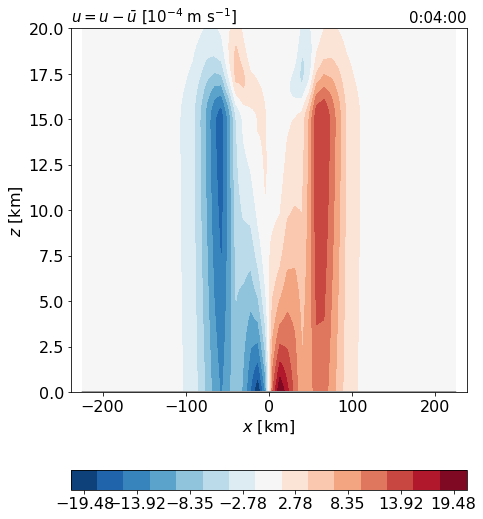

In [ ]:
# Simulation settings
dt = nl.timestep
nt = nl.niter
 
# Integrate
for i in range(nt):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1) * dt)
  
    # Compute the dynamics
    state_prv = dycore(state, {}, dt)
    
    # Compute the physics, and couple it with the dynamics
    _ = ps(state=state, state_prv=state_prv, timestep=dt)
    
    # Step the state
    state.update(state_prv)
  
    if (nl.print_frequency > 0) and ((i + 1) % nl.print_frequency == 0):
        u = state['x_velocity_at_u_locations'].to_units('m s^-1').values[...]
        v = state['y_velocity_at_v_locations'].to_units('m s^-1').values[...]
  
        umax, umin = u.max(), u.min()
        vmax, vmin = v.max(), v.min()
        cfl = max(umax * dt.total_seconds() / grid.dx.to_units('m').values.item(),
                  vmax * dt.total_seconds() / grid.dy.to_units('m').values.item())
 
        # Print useful info
        print('Iteration {:6d}: CFL = {:4f}, umax = {:8.4f} m/s, umin = {:8.4f} m/s, '
              'vmax = {:8.4f} m/s, vmin = {:8.4f} m/s'.format(i+1, cfl, umax, umin, vmax, vmin))
 
    if (nl.filename is not None) and (((nl.save_frequency > 0) and ((i + 1) % nl.save_frequency == 0)) or i + 1 == nt):
        # Save the solution
        netcdf_monitor.store(state)

    if (nl.plot_frequency > 0) and ((i+1) % nl.plot_frequency == 0):
        # Plot the solution
        monitor.plot_properties['title_right'] = str((i+1)*dt)
        fig, _ = monitor.store(state, show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')

Post-processing
--

In [ ]:
if nl.filename is not None:
    netcdf_monitor.write()